# IMAGE CAPTION BOT

### Import Libraries 

In [1]:
import re
import cv2
import string
import json
import nltk
import pickle
import keras
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from nltk.corpus import stopwords
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model,load_model
from keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers import add

Using TensorFlow backend.


### Data Collection

In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions
captions = readTextFile("./Data/Flickr_TextData/Flickr8k.token.txt")

In [3]:
# Total Number of Captions
len(captions.split('\n'))

40461

In [4]:
# Creating a list of Captions
captions = captions.split('\n')

In [5]:
# Captions for the First Image
captions[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [6]:
# Last Caption is an empty string
print(captions[-1])
print(captions[-2])


997722733_0cb5439472.jpg#4	A rock climber practices on a rock climbing wall .


In [7]:
# Discarding Last Caption
captions = captions[:-1]
print(captions[-1])
print(captions[-2])

997722733_0cb5439472.jpg#4	A rock climber practices on a rock climbing wall .
997722733_0cb5439472.jpg#3	A rock climber in a red shirt .


In [8]:
# Total Captions
print(len(captions))

40460


In [9]:
# Dividing Image Id and Caption
print(captions[0].split('\t'))
print(captions[0].split('\t')[0].split('.')[0])
print(captions[0].split('\t')[1])

['1000268201_693b08cb0e.jpg#0', 'A child in a pink dress is climbing up a set of stairs in an entry way .']
1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


#### Dictionary to Map each Image with it's 5 Captions 

In [10]:
descriptions = {}
for x in captions:
    image_id = x.split('\t')[0].split('.')[0]
    image_caption = x.split('\t')[1]
    if descriptions.get(image_id) is None:
        descriptions[image_id] = []
    descriptions[image_id].append(image_caption)

In [11]:
# Description Dictionary
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

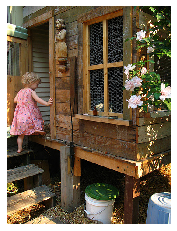

In [12]:
# Checking Images in Dataset
IMG_PATH = "Data/Images/"
img = cv2.imread(IMG_PATH + "1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Data Cleaning

In [13]:
# Unlike in Sentiment Analysis where we remove stopwords we should remember that we have to generate 
# english sentences and should not remove any stopwords neither should we perform stemming.
# But what we can do is Convert all sentences to lower cases, remove digits and punctuations which will 
# help to reduce vocab size. Less Vocab means less neurons means less parameters means less overfitting 
# and less computation

In [14]:
def cleanText(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence) # Replace all character that are not from a-z with " "
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1] # We will check later removing chars effects or not
    sentence = " ".join(sentence)
    return sentence

In [15]:
# Cleaning all the Captions
for image_id,image_captions in descriptions.items():
    for i in range(len(image_captions)):
        image_captions[i] = cleanText(image_captions[i])

In [16]:
# Description Dictionary After Cleaning
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [17]:
# Write all the data in Descriptions Dictionary into a New Text File
with open("Descriptions_1.txt","w") as f:
    f.write(str(descriptions))

### Creating Vocabulary

In [18]:
# Vocab is set of all unique words that your model can predict and we will remove certain words which have 
# count value lesser than a certain threshold

In [19]:
descriptions = None
with open("Descriptions_1.txt",'r') as f:
    descriptions = f.read()

In [20]:
print(type(descriptions))

<class 'str'>


In [21]:
# Converting the String to JSON format to the convert into a Dictionary
json_acceptable_string = descriptions.replace("'","\"") # Single Quote to Double Quote
descriptions = json.loads(json_acceptable_string)

In [22]:
print(type(descriptions))

<class 'dict'>


In [23]:
# Set contains all unique words
# For each caption for a particular image ID we split that sentence 
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

In [24]:
# Number of Distinct Words : in Vocab
print("Vocab Size: %d"% len(vocab))

Vocab Size: 8424


In [25]:
# Total Words across all Sentences
total_words = []
for key in descriptions.keys():
    for des in descriptions[key]:
        for i in des.split():
            total_words.append(i)

In [26]:
print("Total Words : %d"% len(total_words))

Total Words : 373837


In [27]:
# Frequency Count of Each Word
counter = collections.Counter(total_words)
frequency_count = dict(counter)

In [28]:
# Sort the Frequency Count Dictionary on the basis of Count in reverse Order
# Here Lambda x points to a key value pair in frequency_count and x[1] denotes count
sorted_frequency_count = sorted(frequency_count.items(),reverse = True,key = lambda x: x[1])

In [29]:
# Filter Words
threshold = 10
sorted_frequency_count = [x for x in sorted_frequency_count if x[1]>threshold]

In [30]:
 total_words = [x[0] for x in sorted_frequency_count]

In [31]:
print("Final Vocab Size: ",len(total_words))

Final Vocab Size:  1845


### Prepare Training | Testing Data

In [32]:
train_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [33]:
# Stored list of IDs in train and test
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [34]:
# Prepare Description for Training Data
# Tweak - Add <s> and <e> Token to Each Caption
train_descriptions = {}
for image_id in train:
    train_descriptions[image_id] = []
    for cap in descriptions[image_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[image_id].append(cap_to_append)

### Transfer Learning : Image Feature Extraction

In [35]:
# Using Pretrained ResNet 50
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()
# Conatins Skip Connections : Last Column as this is not a Sequential Model and it soles the issue 
# of Vanishing Gradients
# This model allows us to extract all the features from the image then we will apply transfer learning
# for generating Captions

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [36]:
# Input from start of ResNet50 and Output from Global Average Pooling Layer: Containing 2048 Feature Vector
model_new = Model(model.input,model.layers[-2].output)

In [39]:
# Now we will Preprocess M Images into suitable form to feed it to ResNet50 M*2048 output will be stored
# Compute only once. Also need a Batch of image to feed to RedNet50 hence we reshape to 4 Dims
def preprocessImage(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0) # Converts img to 1*224*224*3 from 224*224*3 for ResNet50
    # Normalisation
    img = preprocess_input(img) # Preprocessing Method Available with resNet 50
    return img

In [47]:
# Coverting image to a Feature Vector of 2048
def encodeImage(img):
    img = preprocessImage(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,)) #From 1*2048 to 2048,
    return feature_vector

In [51]:
# Encode all the images in the Dataset and we will store them to use later without extensive computation
encoding_train = {}
start = time();
for index,image_id in enumerate(train):
    image_path = IMG_PATH+"/"+image_id+".jpg"
    encoding_train[image_id] = encodeImage(image_path)
    if(index%100==0):
        print("Encoding in Progress | Time Step : ",index)
end = time()
print("Total Time Taken : ",end - start)

Encoding in Progress | Time Step :  0
Encoding in Progress | Time Step :  100
Encoding in Progress | Time Step :  200
Encoding in Progress | Time Step :  300
Encoding in Progress | Time Step :  400
Encoding in Progress | Time Step :  500
Encoding in Progress | Time Step :  600
Encoding in Progress | Time Step :  700
Encoding in Progress | Time Step :  800
Encoding in Progress | Time Step :  900
Encoding in Progress | Time Step :  1000
Encoding in Progress | Time Step :  1100
Encoding in Progress | Time Step :  1200
Encoding in Progress | Time Step :  1300
Encoding in Progress | Time Step :  1400
Encoding in Progress | Time Step :  1500
Encoding in Progress | Time Step :  1600
Encoding in Progress | Time Step :  1700
Encoding in Progress | Time Step :  1800
Encoding in Progress | Time Step :  1900
Encoding in Progress | Time Step :  2000
Encoding in Progress | Time Step :  2100
Encoding in Progress | Time Step :  2200
Encoding in Progress | Time Step :  2300
Encoding in Progress | Time 

In [53]:
#Storing The Train Data Image Feature Vectors onto the disk
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [54]:
# For Testing Data creating and storing the Featur Vector for each ID
encoding_test = {}
start = time();
for index,image_id in enumerate(test):
    image_path = IMG_PATH+"/"+image_id+".jpg"
    encoding_test[image_id] = encodeImage(image_path)
    if(index%100==0):
        print("Encoding in Progress | Time Step : ",index)
end = time()
print("Total Time Taken : ",end - start)

Encoding in Progress | Time Step :  0
Encoding in Progress | Time Step :  100
Encoding in Progress | Time Step :  200
Encoding in Progress | Time Step :  300
Encoding in Progress | Time Step :  400
Encoding in Progress | Time Step :  500
Encoding in Progress | Time Step :  600
Encoding in Progress | Time Step :  700
Encoding in Progress | Time Step :  800
Encoding in Progress | Time Step :  900
Total Time Taken :  119.38420987129211


In [55]:
#Storing The Test Data Image Feature Vectors onto the disk
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

### Data Preprocessing : Captions

In [56]:
# Create Dictionary for word to index and index to word mapping
# We reserve index 0 for word not present in sentence
word_to_index = {}
index_to_word = {}
for index,word in enumerate(total_words):
    word_to_index[word] = index+1
    index_to_word[index+1] = word

In [59]:
# Now we need to add startseq and endseq to our dictionary
# Checking Size of Dictionary
print(len(word_to_index))

1845


In [60]:
index_to_word[1846] = "startseq"
word_to_index["startseq"] = 1846
index_to_word[1847] = "endseq"
word_to_index["endseq"] = 1847

In [67]:
# The Dictionary does not contain 0 indexing
vocab_size = len(word_to_index) + 1
print("Vocab Size : ",vocab_size)

Vocab Size :  1848


In [69]:
# Finding Maximum Length of a Caption
max_length = 0
for image_id in train_descriptions.keys():
    for caption in train_descriptions[image_id]:
        max_length = max(max_length,len(caption.split()))
print(max_length)

35


In [70]:
# In Markov Chain while Generating Sentences you can just see previous words but in RNN or LSTM you can see
# entire sequence of words. There will be multiple training points for 1 caption where our model will learn
# how to predict. Here we provide a part of a sentence and tell the model that our next word is lets say
# running and train your self such that you can predict running then we provide last sentence+running and 
# tell next word in on and please learn to predict on as your next word. Hence we are just feeding the 
# correct sentence in consective increasing sequence regardless of what output it generates.

### Data Generator

In [71]:
# Data Generator generally helps in keeping part of data in memory in the form of batches if the data is
# very large. Total we have 6000 images with 5 captions each making a total of 30000 captions. Then 1 
# caption will have length of caption training data points. This is why we require Data Generator. Then we 
# will have a Data matrix which will hold image vector of 2048 columns plus Length of Partial Caption(x).
# x will be higher than max length of caption as every word or its index will be mapped(embedded) to higher
# dimensional space. We will create an embedding layer mapping each word to some vector which will be fed 
# to RNN Cells. We will be using Glove Vectors for this instead of training from scratch.  

In [111]:
def dataGenerator(train_descriptions,encoding_train,word_to_index,max_length,batch_size):
    X1 = []
    X2 = []
    y = []
    n = 0
    while True:
        for image_id,captions in train_descriptions.items():
            n = n + 1
            pic = encoding_train[image_id+".jpg"]
            for caption in captions:
                sequence = [word_to_index[word] for word in caption.split() if word in word_to_index]
                for i in range(1,len(sequence)):
                    xi = sequence[0:i]
                    yi = sequence[i]
                    xi = pad_sequences([xi],maxlen=max_length,value=0,padding="post")[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    X1.append(pic)
                    X2.append(xi)
                    y.append(yi)
                    
                if(n==batch_size):
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1 = []
                    X2 = []
                    y = []
                    n = 0

### Transfer Learnings : Word Embeddings

In [82]:
# Opening the Word Embedding File containing 6 Billion Words with a 50 feature vector
f = open("glove.6B.50d.txt",encoding='utf-8')

In [83]:
# Creating a Dictionary of these words along with their feature vector
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype="float")
    embedding_index[word] = word_embedding

In [85]:
# Closing the File
f.close()

In [86]:
# Now we do not need 6 Billion Words...We just need feature vectors of those words which are aready in 
# our vocab and hence we will create a new matrix containing those words along with feature vectors

In [87]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,index in word_to_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            matrix[index] = embedding_vector
    return matrix

In [88]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


### Model Architecture

In [ ]:
# Main Function of Model : Take Image Features and Partial Sequences as input and output next word for the 
# sequence and append that word to the partial sequence and the cycle continues until you recieve endseq.
# We have a partial caption that goes through an embedding layer which is fed to a RNN Layer which produces
# some hidden vector (captures state of sentence build so far) which is combined with the image feature 
# vector and are fed to an MLP which will contain a Dense Layer with lot of Neurons equal to vocab size and
# the model predicts next word in the sequence of partial caption.

In [90]:
# Imgae Feature Extractor Model : 2048 Feature Vector to 256 Dimensional Vector : Represents image
input_image_features = Input(shape=(2048,))
input_img1 = Dropout(0.3)(input_image_features)
input_img2 = Dense(256,activation='relu')(input_img1)

In [91]:
# Partial Caption Sequence Model : Get 256 Dimension Vector : Represents Text
input_captions = Input(shape=(max_length,))
input_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
input_cap2 = Dropout(0.3)(input_cap1)
input_cap3 = LSTM(256)(input_cap2)

In [92]:
# Decoder : Concatenates Both Models
decoder1 = add([input_img2,input_cap3])
decoder2 = Dense(256,activation="relu")(decoder1)
outputs = Dense(vocab_size,activation="softmax")(decoder2)

In [93]:
# Combined Model
model = Model(inputs=[input_image_features,input_captions],outputs=outputs)

In [94]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [95]:
# Already Trained Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [96]:
model.compile(loss="categorical_crossentropy",optimizer="adam")

### Training of Model

In [102]:
epochs = 20
batch_size = 3
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [103]:
def train():
    for i in range(epochs):
        generator = dataGenerator(train_descriptions,encoding_train,word_to_index,max_length,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [117]:
train()

Epoch 1/1
1000/1000 [==============================] - 185s 185ms/step - loss: 3.8410
Epoch 1/1
1000/1000 [==============================] - 190s 190ms/step - loss: 3.5250
Epoch 1/1
1000/1000 [==============================] - 190s 190ms/step - loss: 3.3036
Epoch 1/1
1000/1000 [==============================] - 184s 184ms/step - loss: 3.1397
Epoch 1/1
1000/1000 [==============================] - 180s 180ms/step - loss: 3.0094
Epoch 1/1
1000/1000 [==============================] - 180s 180ms/step - loss: 2.8921
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 2.7986
Epoch 1/1
1000/1000 [==============================] - 205s 205ms/step - loss: 2.7247
Epoch 1/1
1000/1000 [==============================] - 184s 184ms/step - loss: 2.6505
Epoch 1/1
1000/1000 [==============================] - 182s 182ms/step - loss: 2.5886
Epoch 1/1
1000/1000 [==============================] - 183s 183ms/step - loss: 2.5339s - 
Epoch 1/1
1000/1000 [=============================

In [118]:
# model = load_model('./model_weights/model_9.h5')

### Predictions

In [127]:
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_length):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence],maxlen=max_length,padding='post')
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = index_to_word[ypred]
        in_text += (' ' + word)
        if word == "endseq":
            break
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

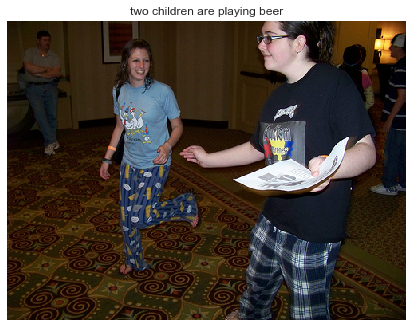

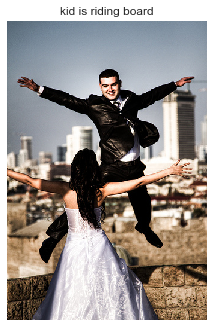

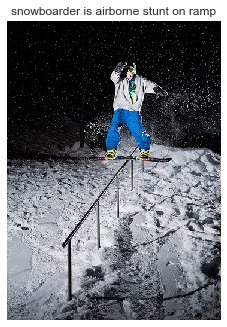

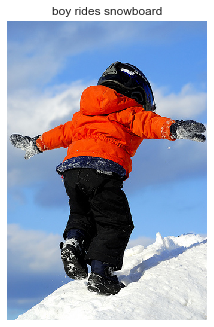

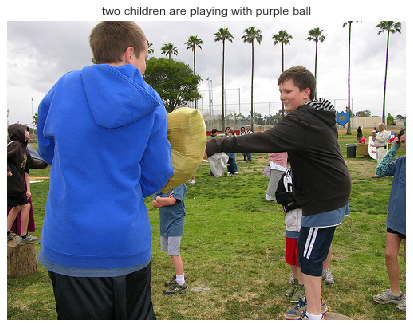

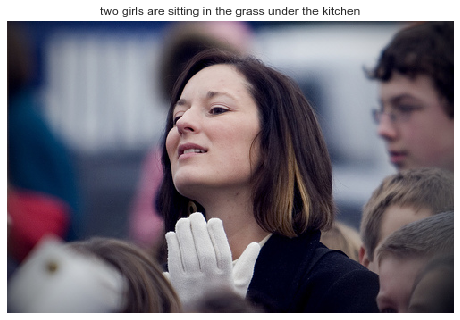

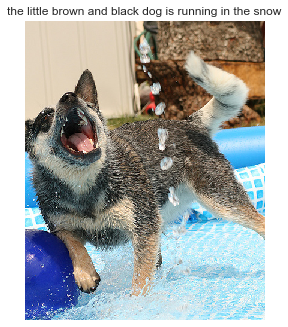

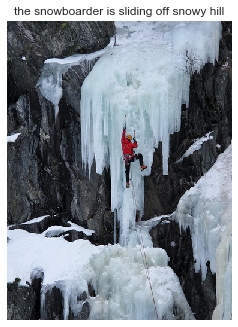

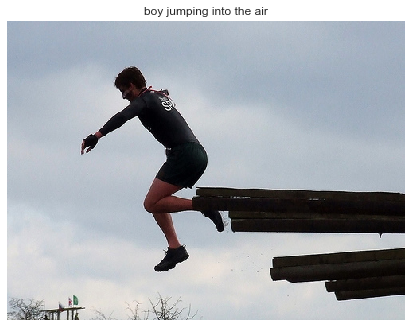

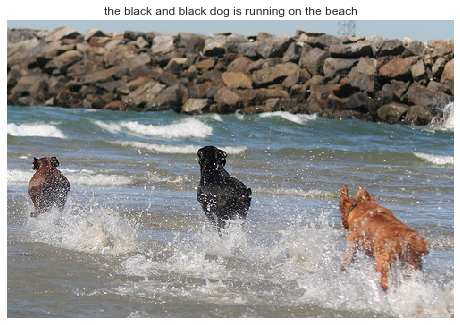

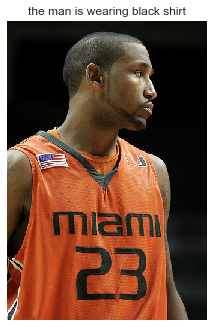

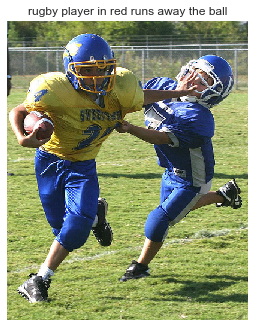

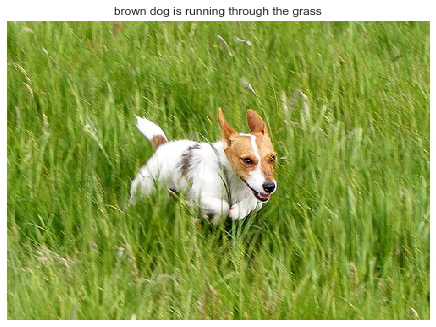

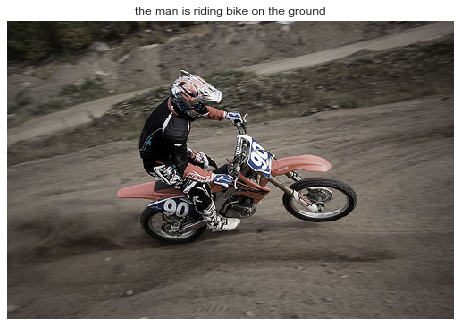

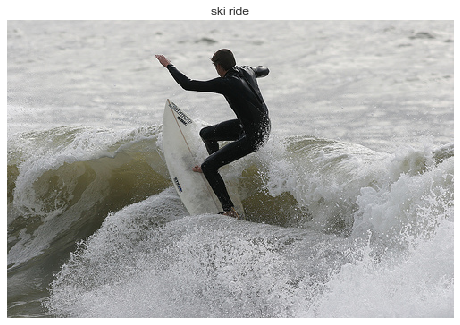

In [129]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()